## Implementation of Capsule Networks
Dataset- COIL 100

In [0]:
!pip install pydrive

    100% |████████████████████████████████| 993kB 25.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations,optimizers
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

#--------------linear algebra, data processing----------#
import numpy as np 
import pandas as pd
import glob,string
import codecs
from tqdm import tqdm

#--------------Google authentication--------------------#
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import tensorflow as tf
from oauth2client.client import GoogleCredentials

### Google authentication
* fetch the dataset from google drive 
* unzip the extracted file 

In [0]:


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
zip_file = drive.CreateFile({'id': '1SVo_UonxSflAzAqWQhqUrJFPLvyTc3vA'})
zip_file.GetContentFile('coil-100.zip')

In [0]:
!unzip 'coil-100.zip'

In [0]:
path = './coil-100/*.png'
#list files
files=glob.glob(path)

## Data processing and visualization

In [0]:
def contructDataframe(file_list):
    data=[]
    for file in tqdm(file_list):
        data.append((file,file.split("/")[-1].split("__")[0]))
    return pd.DataFrame(data,columns=['path','label'])

In [0]:
df=contructDataframe(files)

100%|██████████| 7200/7200 [00:00<00:00, 416825.24it/s]


In [0]:
print(df.head())
print(df.tail())

                        path   label
0  ./coil-100/obj94__220.png   obj94
1   ./coil-100/obj66__75.png   obj66
2  ./coil-100/obj100__45.png  obj100
3  ./coil-100/obj59__315.png   obj59
4  ./coil-100/obj80__315.png   obj80
                           path  label
7195   ./coil-100/obj17__15.png  obj17
7196   ./coil-100/obj9__110.png   obj9
7197   ./coil-100/obj28__30.png  obj28
7198   ./coil-100/obj67__15.png  obj67
7199  ./coil-100/obj51__175.png  obj51


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.path, df.label, test_size=0.20,random_state=0,stratify= df.label)

In [0]:
from keras.preprocessing.image import load_img,img_to_array
import cv2
X_train=[img_to_array(cv2.imread(file).astype("float")/255.0) for file in tqdm(X_train.values)]

Using TensorFlow backend.
100%|██████████| 5760/5760 [00:05<00:00, 998.13it/s] 


In [0]:
X_test=[img_to_array(cv2.imread(file).astype("float")/255.0) for file in tqdm(X_test.values)]

100%|██████████| 1440/1440 [00:01<00:00, 992.70it/s]


In [0]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_categorical=encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_categorical=encoder.transform(y_test.values.reshape(-1, 1))

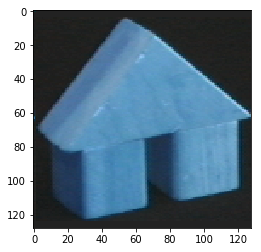

In [0]:
import matplotlib.pyplot as plt
img = X_train[49]
plt.imshow(img)
plt.show()

## Data Augmentation
We're implementing data augmentation feature to improve and help the model to train on larger size of database

In [0]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

## Capsule Network Modeling

In [0]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


batch_size = 16
num_classes = 100
epochs = 50

# A common Conv2D model
input_image = Input(shape=(128,128, 3))
x = Conv2D(64, (5, 5), activation='relu')(input_image)
#x= MaxPooling2D((2,2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Dropout(0.2)(x)
#x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((3, 3))(x)
#x = Conv2D(256, (3, 3), activation='relu')(x)
x = Dropout(0.2)(x)
#x = MaxPooling2D((2, 2))(x)
#x = Conv2D(512, (3, 3), activation='relu')(x)
#x = Dense((128))(x)
x = Dense((512))(x)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x = Reshape((-1, 128))(x)
capsule = Capsule(num_classes, 32, 3, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# we use a margin loss
#adam = K.optimizers.Adam(lr=0.001)
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 124, 124, 64)      4864      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 122, 122, 128)     73856     
_________________________________________________________________
dropout_35 (Dropout)         (None, 122, 122, 128)     0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 40, 40, 128)       0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 40, 40, 128)       0         
_________________________________________________________________
dense_35 (Dense)             (None, 40, 40, 512)       66048     
__________

In [0]:
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [0]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [0]:
# hist = model.fit(
#         X_train,
#         y_train_categorical,
#         batch_size=batch_size,
#         epochs=epochs,
#         validation_data=(X_test, y_test_categorical),
#         shuffle=True,)

hist = model.fit_generator(aug.flow(X_train, y_train_categorical, batch_size=batch_size),steps_per_epoch=len(X_train)//batch_size,
                           epochs=epochs,
                           validation_data=(X_test, y_test_categorical),
                           verbose=1,callbacks=callbacks_list)

Epoch 1/50
360/360 [==============================] - 326s 904ms/step - loss: 0.6524 - acc: 0.1260 - val_loss: 0.5783 - val_acc: 0.1118
Epoch 2/50
360/360 [==============================] - 321s 891ms/step - loss: 0.5133 - acc: 0.3033 - val_loss: 0.5068 - val_acc: 0.2812
Epoch 3/50
360/360 [==============================] - 319s 885ms/step - loss: 0.4473 - acc: 0.4778 - val_loss: 0.4152 - val_acc: 0.5521
Epoch 4/50
360/360 [==============================] - 319s 887ms/step - loss: 0.4006 - acc: 0.6024 - val_loss: 0.4087 - val_acc: 0.5722
Epoch 5/50
360/360 [==============================] - 319s 886ms/step - loss: 0.3636 - acc: 0.6722 - val_loss: 0.3566 - val_acc: 0.7021
Epoch 6/50
360/360 [==============================] - 318s 883ms/step - loss: 0.3294 - acc: 0.7337 - val_loss: 0.3269 - val_acc: 0.7076
Epoch 7/50
360/360 [==============================] - 322s 893ms/step - loss: 0.3004 - acc: 0.7858 - val_loss: 0.2971 - val_acc: 0.7701
Epoch 8/50
360/360 [============================

In [0]:
import matplotlib.pyplot as plt
def plotter(trained_record):
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(trained_record.history['loss'],'r',linewidth=3.0)
    plt.plot(trained_record.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.savefig('loss.png')
    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(trained_record.history['acc'],'r',linewidth=3.0)
    plt.plot(trained_record.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.savefig('accuracy.png')

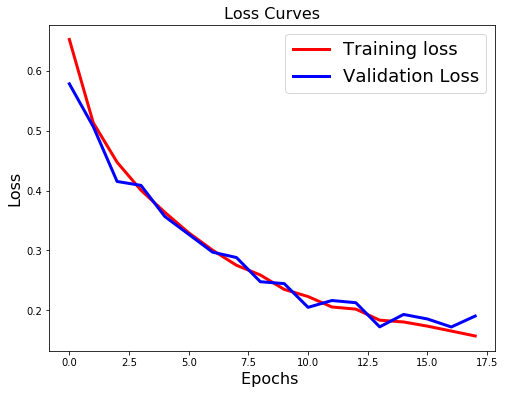

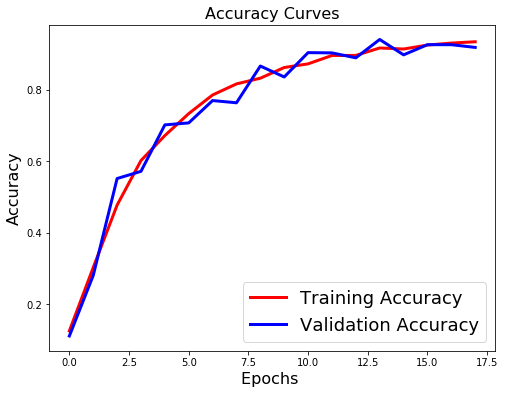

In [0]:
plotter(hist)